In [ ]:
# default_exp core

In [ ]:
#hide
import sys
sys.path.append('..')
import pandas as pd

/home/tako/dev/env37/lib/python3.7/site-packages/pandas/compat/__init__.py:85: UserWarning: Could not import the lzma module. Your installed Python is incomplete. Attempting to use lzma compression will result in a RuntimeError.
  warnings.warn(msg)
/home/tako/dev/env37/lib/python3.7/site-packages/pandas/compat/__init__.py:85: UserWarning: Could not import the lzma module. Your installed Python is incomplete. Attempting to use lzma compression will result in a RuntimeError.
  warnings.warn(msg)


In [ ]:
# hide
from nbdev.showdoc import *
from fastcore.test import *

In [ ]:
#export
from fastcore.all import *
from fastai2.basics import *
import pandas as pd
import numpy as np

# Core functions

> API details.

In [ ]:
# export
class TSeries(TensorBase):pass   

In [ ]:
#export

def no_emp_dim(x): 
    if len(x.shape)==1 :
        x = x[None,:]
    return np.vstack(x)

def show_graph(array, ax=None, figsize=None, title=None, ctx=None, tx=None, **kwargs):    
    "Show an array on `ax`."
    # Handle pytorch axis order
    if hasattrs(array, ('data','cpu','permute')):
        array = array.data.cpu()
    elif not isinstance(array,np.ndarray): 
        array=array(array)
    arrays = no_emp_dim(array)
    ax = ifnone(ax,ctx)
    if figsize is None: figsize = (5,5)
    if ax is None: _,ax = plt.subplots(figsize=figsize)
    tx = ifnone(tx,np.arange(arrays[0].shape[0]))
    label = kwargs.pop('label', 'x')
    for a, c in zip(arrays, ['b', 'c', 'm', 'y', 'k',]):
        ax.plot(tx, a, '-*'+c,label=label, **kwargs)
        
    if title is not None: ax.set_title(title)
    
    ax.legend()
#     ax.axis('off')
    return ax

In [ ]:
# export
def test_graph_exists(ax):
    "Test there is a graph displayed in `ax`"
    assert ax 

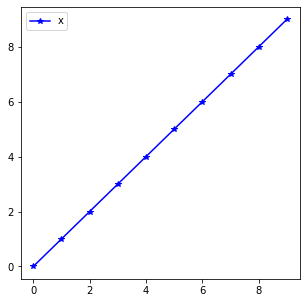

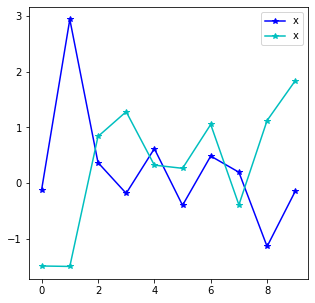

In [ ]:
# hide
a = TSeries(np.arange(10))
ax = show_graph(a)
test_graph_exists(ax)

a = TSeries(np.random.randn(2,10))[None,:]
ax = show_graph(a)
test_graph_exists(ax)

show_graph can show an array...

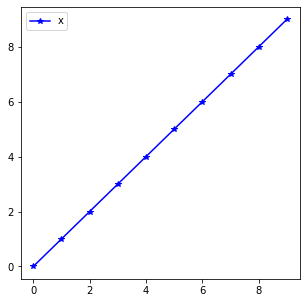

In [ ]:
a = np.arange(10)
ax = show_graph(a)

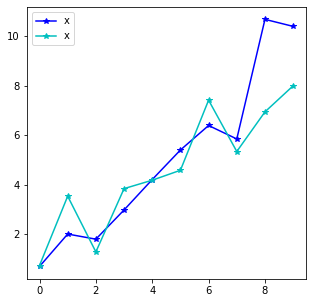

In [ ]:
a = tensor(np.arange(10)+np.random.randn(2,10))[None,:]
ax = show_graph(a)

In [ ]:
# export
class TensorSeq(TensorBase): 
    def show(self, ctx=None, **kwargs):
        return show_graph(self, ctx=ctx, **kwargs)

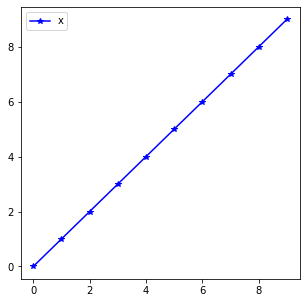

In [ ]:
ax = TensorSeq(np.arange(10)).show()

In [ ]:
# export
class TSTensorSeq(TensorSeq): pass
class TSTensorSeqy(TensorSeq): 
    
    @classmethod
    def create(cls, t)->None:
        "Convert an array or a list of points `t` to a `Tensor`"
        return cls(tensor(t).float())
    
    def show(self, ctx=None, **kwargs):
        if 'figsize' in kwargs: 
            del kwargs['figsize']
        array = np.array(self.cpu())
        array = no_emp_dim(array)
        x_len = self._meta.get('x_len',0)
        m = self._meta.get('m','-*g')
        label = self._meta.get('label','y')
        t = np.arange(x_len,x_len+array.shape[1])[None,:]
        ctx.plot(t.T, array.T, m, label=label, **kwargs)
        ctx.legend()
        return ctx

TSTensorSeqy.loss_func = MSELossFlat()

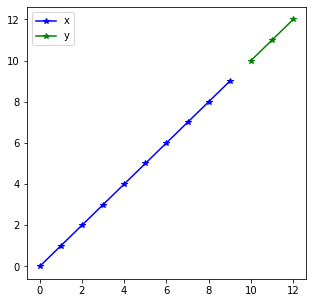

In [ ]:
ts = TSTensorSeq(np.arange(10))
ctx = ts.show()

y = TSTensorSeqy(np.array([10,11,12]), x_len=10)
y.show(ctx=ctx)

In [ ]:
#export
from fastai2.vision.data import *

@delegates(subplots)
def show_graphs(arrays, rows=None, cols=None, figsize=None, titles=None, **kwargs):
    "Show all images `arrays` as subplots with `rows` using `titles`"
    if titles is None: titles = [None]*len(arrays)
    axs = get_grid(len(arrays), rows=rows, cols=cols, add_vert=1, figsize=figsize)
    for a,t,ax in zip(arrays, titles, axs): 
        ctx = show_graph(a[0], ax=ax, title=t)
        for y in a[1:]:
            ctx = y.show(ctx=ctx)
    return axs

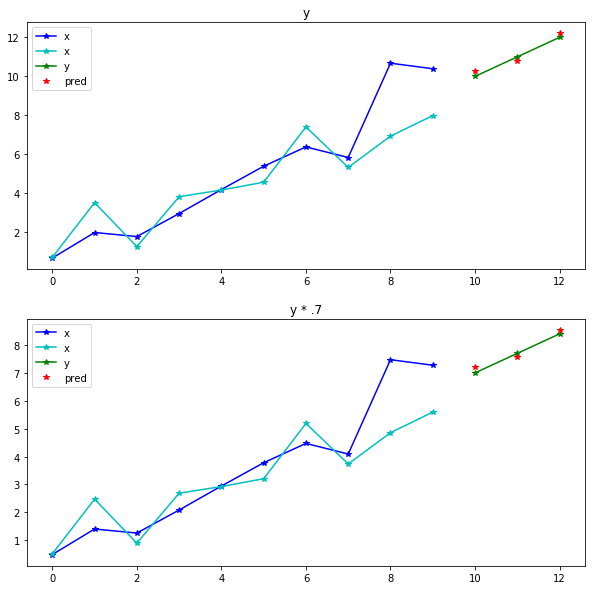

In [ ]:
y_hat = TSTensorSeqy(np.array([10.3,10.8,12.2]), x_len=10, m='*r', label='pred')

show_graphs(((a, y, y_hat), (a*.7, y*.7, y_hat*.7)), titles=('y','y * .7'), figsize=(10,10))

In [ ]:
# hide
test_graph_exists(ax)

# Utils

In [ ]:
# export

def concat_dct(new_dct, expand_dct):
    """Concatanates `torch.tensor`'s in `new_dct` to the same `key` in expand_dct'."""
    for k,v in new_dct.items():
        if isinstance(v,torch.Tensor):
            if k in expand_dct:                
                expand_dct[k] = torch.cat([expand_dct[k],v], axis = 0)
            else:
                expand_dct[k] = v
        else:
            if k in expand_dct:
                expand_dct[k] = concat_dct(new_dct[k], expand_dct[k])
            else: 
                expand_dct[k] = concat_dct(new_dct[k], {})
            
    return expand_dct

In [ ]:
dct = defaultdict(dict)
new_d = {'foo':{'bar':torch.randn(4,4)}}
dct = concat_dct(new_d, dct)
print(dct['foo']['bar'].shape)
new_d = {'foo':{'bar':torch.randn(4,4)+10}}
dct = concat_dct(new_d, dct)
print(dct['foo']['bar'].shape)
new_d = {'foo':{'bar':torch.randn(8,4)+10}}
dct = concat_dct(new_d, dct)
print(dct['foo']['bar'].shape)

torch.Size([4, 4])
torch.Size([8, 4])
torch.Size([16, 4])


In [ ]:
# export
def pad_zeros(X, lenght):
    return  np.pad(
                X, 
                pad_width=((0, 0), (lenght - X.shape[-1], 0)), 
                mode='constant', 
                constant_values=0
            )

In [ ]:
# export
def Skip(percentage_remove):
    """Helper function for `pd.read_csv` and will randomly not load `percentage_remove`% of the whole dataset """
    
    def skip(x):
        if (np.random.rand() < percentage_remove or x == 0):
            return False
        return True
    return skip

In [ ]:
l = []
skip = Skip(.9)
for i in range(10000):
    if not skip(i):
        l.append(1)
    else:
        l.append(0)    
test_eq(l[0],1)
test_close(np.mean(l),.9,.01)

In [ ]:
from fastseq.data.all import *
from fastai2.basics import *
path = untar_data(URLs.m4_daily)
pd.read_csv(path/'val.csv',skiprows = Skip(.9))

,V1,V2,V3,V4,V5,V6,V7,V8,V9,V10,V11,V12,V13,V14,V15
0,D1,2039.2000,2035.0000,2051.8000,2061.8000,2063.5000,2069.5000,2054.0000,2057.0000,2062.8000,2066.4000,2067.4000,2071.4000,2083.800,2080.6000
1,D3,1120.7000,1117.9000,1115.1000,1112.3000,1109.5000,1106.7000,1103.9000,1101.1000,1098.3000,1095.5000,1092.7000,1089.9000,1087.100,1084.3000
2,D6,3182.0525,3147.0985,3143.8503,3128.2005,3229.8279,3263.2599,3303.5956,3314.0879,3335.8389,3314.8839,3403.4529,3424.7502,3280.184,3338.7257
3,D7,5860.0080,7773.2460,9477.8720,8209.0990,7421.2360,6677.5970,8235.9980,7850.5550,7280.3130,6888.8830,3432.2460,4800.4470,4021.873,3483.4570
4,D8,1732.2000,1731.8300,1739.1700,1741.8000,1738.5000,1748.9400,1746.3100,1754.0500,1750.3300,1735.5400,1739.4600,1734.6900,1732.070,1730.4400
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3843,D4223,3050.0000,3125.0000,3262.0000,3262.0000,3520.0000,3520.0000,3515.0000,3494.0000,3494.0000,3494.0000,3494.0000,3494.0000,3494.000,3494.0000
3844,D4224,3719.0000,3754.0000,3754.0000,3721.0000,3730.0000,3727.0000,3700.0000,3700.0000,3708.0000,3708.0000,3708.0000,3708.0000,3708.000,3708.0000
3845,D4225,4014.0000,4023.0000,4056.0000,4070.0000,4085.0000,4095.0000,4118.0000,4110.0000,4159.0000,4167.0000,4145.0000,4168.0000,4068.000,4066.0000
3846,D4226,1486.2200,1501.3900,1502.1500,1497.6400,1489.7200,1494.7500,1497.4100,1500.5700,1492.2000,1489.0800,1495.5600,1488.2100,1493.630,1487.3000


In [ ]:
#export
# TODO skip will skip different rows for train and val

def get_ts_files(path, recurse=True, folders=None, **kwargs):
    "Get image files in `path` recursively, only in `folders`, if specified."
    items = []
    for f in get_files(path, extensions=['.csv'], recurse=recurse, folders=folders):
        df = pd.read_csv(f, **kwargs)
        items.append(ts_lists(df.iloc[:, 1:].values))
    return items

In [ ]:
# train, val = get_ts_files(path, nrows=1000)

In [ ]:
# export
def IndexsSplitter(train_idx, val_idx=None, test=None):
    """Split `items` from 0 to `train_idx` in the training set, from `train_idx` to `val_idx` (or the end) in the validation set. 
    
    Optionly if `test` will  in test set will also make test from val_idx to end.
    """
    _val_idx = ifnone(val_idx,-1)
    do_test = ifnone(test, False)
    def _inner(items, **kwargs):
        if _val_idx == -1:
            val_idx = len(items)
        else:
            val_idx = _val_idx
        train = L(np.arange(0, train_idx), use_list=True)
        valid = L(np.arange(train_idx, val_idx), use_list=True)
        if do_test:
            test = L(np.arange(val_idx,len(items)), use_list=True)
            return train, valid, test
        if not val_idx == len(items):
            warnings.warn("You lose data")
        return train, valid
    return _inner

In [ ]:
items = list(range(10))
splitter = IndexsSplitter(5,8)
test_eq(splitter(items),(L(0,1,2,3,4),L(5,6,7)))

/home/tako/dev/env37/lib/python3.7/site-packages/ipykernel_launcher.py:20: UserWarning: You lose data


In [ ]:
splitter = IndexsSplitter(5,8,True)
test_eq(splitter(items),(L(0,1,2,3,4),L(5,6,7),L(8,9)))

# Preprocces functions

## M4

In [ ]:
# export
def ts_lists(ts:np.ndarray)-> L:
    """Transforms a `np.ndarray` of shape (timeseries, max_time) to a list of timeseries with shape (1,time).
    
    where:
    
    max_time = the length of the longest timeserie
    
    time = the length of the non-nan values of that specific timeserie    
    """
    lst = L()
    for time_series in ts:
        lst.append(time_series[~np.isnan(time_series)][None,:])
    return lst

In [ ]:
# hide
ts = np.array([np.arange(0,10.),
               np.arange(0,10.)
              ])
ts[1,-1] = np.NaN

r = ts_lists(ts)
test_eq(r[0],np.arange(0,10.)[None,:])
test_eq(r[1],np.arange(0,9.)[None,:])
test_eq(r[0].shape,(1,10))

In [ ]:
ts

array([[ 0.,  1.,  2.,  3.,  4.,  5.,  6.,  7.,  8.,  9.],
       [ 0.,  1.,  2.,  3.,  4.,  5.,  6.,  7.,  8., nan]])

In [ ]:
ts_lists(ts)

(#2) [array([[0., 1., 2., 3., 4., 5., 6., 7., 8., 9.]]),array([[0., 1., 2., 3., 4., 5., 6., 7., 8.]])]

In [ ]:
# hide
from nbdev.export import *
notebook2script()

Converted 00_core.ipynb.
Converted 01_data.external.ipynb.
Converted 02_data.load.ipynb.
Converted 03_data.core.ipynb.
Converted 03_data.transforms.ipynb.
Converted 04_metrics.ipynb.
Converted 05_models.nbeats.ipynb.
Converted 07_interpret.ipynb.
Converted 100_readme_alt.ipynb.
Converted 21_data.loadpandas.ipynb.
Converted index.ipynb.
